# Pytorch és Numpy főbb összehasonlítása

In [ ]:
import numpy as np
import torch

A Pytorch szintaxisa, függvény nevei vektorizált műveletek esetén nagyon hasonlít a Numpy-hoz. Azonban akadnak különbségek

In [ ]:
a = torch.tensor([1, 4, 6, 7]) # array helyett tensor-nak nevezi a pytorch a tömböket
a = torch.zeros(10)
a = torch.arange(10, dtype=torch.float32)
print(a)
a = torch.rand((10,2))
a.sum(dim=1) # az axis helyett dim kulcsszót használ

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])


tensor([0.6947, 1.2844, 0.5525, 0.7235, 0.5141, 1.5224, 1.2505, 0.7877, 0.7465,
        0.8854])

A pytorch lehetővé teszi a GPU-n való művelet végzést.

In [ ]:
print(a.device)
a_cuda = torch.arange(10, device='cuda:0')
print(a_cuda.device)
a.to('cuda:0', dtype=bool)

Beépített automatikus deriválás a háttérben.

In [ ]:
x = torch.tensor([2.0], requires_grad=True)
y = torch.log(x)

gradient = torch.autograd.grad(y, x)

print("Original value:", x.item())
print("Gradient:", gradient[0].item())

Original value: 2.0
Gradient: 0.5


A neurális hálók készítéséhez szükséges legtöbb építőelem a Pytorch-ban már előre le van implementálva.

In [ ]:
import torch.nn as nn #neurális hálók modul

x = torch.rand(32, 4)
linear_layer = nn.Linear(4, 8, bias=True, device='cpu')
y = linear_layer(x)

W = torch.rand((4+1, 8))
x = torch.cat([x, torch.ones((32, 1))], dim=-1)
y = x @ W

# Regresszió Pytorch-al

### Adatbázis betöltése

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()

features = pd.DataFrame(housing.data, columns=housing.feature_names)

target = pd.DataFrame(housing.target, columns=['MEDV'])

print(features.head())
print(target.head())
print(features.describe())
print(target.describe())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
    MEDV
0  4.526
1  3.585
2  3.521
3  3.413
4  3.422
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25% 

### Adatbázis felosztása

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_rest, y_train, y_rest = train_test_split(features.values, target.values, train_size=0.7, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42)

# Adatfelsorolók létrehozása

In [ ]:
from torch.utils.data import Dataset, DataLoader

class HousingDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

train_dataset = HousingDataset(x_train, y_train)
val_dataset = HousingDataset(x_val, y_val)
test_dataset = HousingDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


print(train_dataset[10])

(tensor([ 1.5086e+00,  1.2000e+01,  3.9837e+00,  9.7003e-01,  1.7080e+03,
         4.6540e+00,  3.6210e+01, -1.2010e+02]), tensor([0.6470]))


### Regressziós modell definiálása

In [ ]:
class RegressionModel(nn.Module):
  def __init__(self, input_dim):
        super().__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

  def forward(self, x):
      return self.linear_relu_layers(x)

### Regressziós modell tanítása

In [ ]:
n_epochs = 20
model = RegressionModel(8)
loss_fn = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(n_epochs):
  model.train()
  train_epoch_losses = []

  for x, y in train_dataloader:
    optimizer.zero_grad()
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    train_epoch_losses.append(loss)
    loss.backward()
    optimizer.step()

  train_epoch_losses = torch.tensor(train_epoch_losses)
  avg_epoch_loss = train_epoch_losses.mean()
  train_losses.append(avg_epoch_loss)

  model.eval()
  val_epoch_losses = []

  for x, y in val_dataloader:
    with torch.no_grad():
      y_hat = model(x)

    loss = loss_fn(y_hat, y)
    val_epoch_losses.append(loss)

  val_epoch_losses = torch.tensor(val_epoch_losses)
  avg_epoch_loss = val_epoch_losses.mean()
  val_losses.append(avg_epoch_loss)

  print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

Tranining 1/20 done, training loss: 465.0420837402344, validation loss: 3.5831713676452637
Tranining 2/20 done, training loss: 2.904792070388794, validation loss: 1.2217167615890503
Tranining 3/20 done, training loss: 1.2435853481292725, validation loss: 1.139128565788269
Tranining 4/20 done, training loss: 1.0469318628311157, validation loss: 0.8219037652015686
Tranining 5/20 done, training loss: 2.3791027069091797, validation loss: 1.0306397676467896
Tranining 6/20 done, training loss: 0.7640678286552429, validation loss: 0.8397340774536133
Tranining 7/20 done, training loss: 0.662739098072052, validation loss: 0.6968150734901428
Tranining 8/20 done, training loss: 0.6523149609565735, validation loss: 0.5903604030609131
Tranining 9/20 done, training loss: 0.6607906818389893, validation loss: 0.5976867079734802
Tranining 10/20 done, training loss: 0.6319504976272583, validation loss: 0.8082907795906067
Tranining 11/20 done, training loss: 0.6436986327171326, validation loss: 0.6014451

### Hiba alakulásának vizualizálása a tanítás során

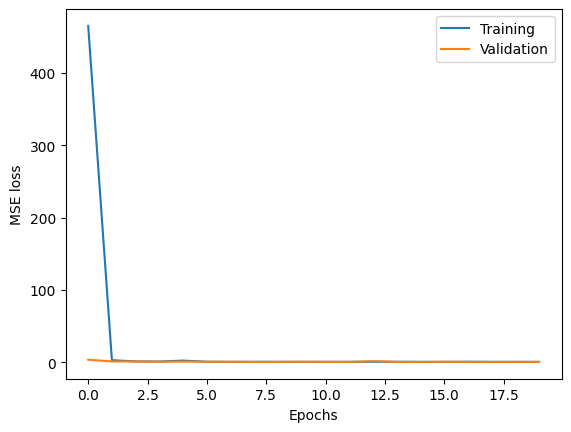

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

# Modell kiértékelése a teszt halmazon

In [ ]:
model.eval()
test_losses = []
prediction_label_pairs = []
for x, y in test_dataloader:
    with torch.no_grad():
      y_hat = model(x)
    loss = loss_fn(y_hat, y)
    prediction_label_pairs.append(torch.concat((y_hat, y), dim=-1))
    test_losses.append(loss)

avg_test_loss = torch.tensor(test_losses).mean()
print('Average loss on the test dataset: ', avg_test_loss.item())
print(prediction_label_pairs[0])

Average loss on the test dataset:  0.5314286351203918
tensor([[1.6513, 0.9200],
        [1.2370, 1.5880],
        [1.1997, 0.5430],
        [1.2010, 1.1170],
        [1.1997, 0.9730],
        [1.2608, 0.8460],
        [2.2513, 1.4000],
        [2.0069, 1.9760],
        [2.7442, 2.5540],
        [2.2412, 3.7600],
        [1.4004, 1.3220],
        [4.1685, 4.5530],
        [2.0472, 2.1840],
        [2.7330, 2.8380],
        [1.1997, 1.0260],
        [1.4105, 0.7290]])


### Modell mentése és betöltése

In [ ]:
model_path = 'model.pth'
torch.save(model.state_dict, model_path)
model.state_dict = torch.load(model_path)